In [214]:
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import scipy.optimize 
from datetime import datetime,time,timedelta
import matplotlib.pyplot as plt
%matplotlib inline

from Strategy.strategy1 import strategy1
from Strategy.strategy2 import strategy2
from Strategy.strategy3 import strategy3

In [300]:
factors = pd.read_csv("./Factors/merge_Factors.csv")
factor_returns = pd.read_csv("./Predict/factors_returns_pred.csv")
stock_raw_data = pd.read_csv("./Data/Raw_Stock_Data.csv")

In [27]:
date = "2022-10-03"
selected_stocks = strategy1(date)
factors = factors.loc[(factors["Date"]==date) & (factors["Index"].isin(selected_stocks))]
factor_returns = factor_returns.loc[factor_returns["Date"]==date]
factor_returns = factor_returns.iloc[:,1:]
stock_list = factors["Index"].tolist()
factors = factors.iloc[:, 3:]
factors = np.array(factors)
factor_returns = np.array(factor_returns)

In [28]:
stock_return = np.dot(factors, factor_returns.T).reshape(-1)
stock_list = np.array(stock_list)

In [29]:
stock_return

array([0.01065462, 0.02895356, 0.04407649, 0.03290185, 0.00890382,
       0.01174139, 0.04829632, 0.04372723, 0.01981285, 0.07887703])

### Test optimize:

In [30]:
from datetime import datetime 

In [34]:
def optimize(weights,tickers,start,end,calc_window,rf_rate,short=False,
             price_type='Close',clean='True'):
          
        '''
        weights; *type = list, initial guess weights
        
        start; input as str, data start date format 'YYYY-MM-DD' 
        end; input as str, data end date format 'YYYY-MM-DD'
        
        calc_window; input as str, calculation window for returns, 
        
        rf_rate; desired risk-free rate to benchmark against
        
        price_type; *input as str, default = 'Close', options = 'Adj Close', 
        'Close', 'High','Low','Open', 'Volume'
        
        short = bool, default = 'False', if true weight bounds -1 to 1
        
        clean; bool, default = 'False', if true, the function will drop NA rows
        '''
        start = datetime.strptime(start,'%Y-%m-%d')
        end = datetime.strptime(end,'%Y-%m-%d')
        
        prices = pdr.get_data_yahoo(tickers, start, end)[price_type]
        
        op = prices.pct_change(periods=int(calc_window))
        op.iloc[-1,:]=stock_return
        if clean == False:
            op
            
        else:
            op = op.dropna()
        
        vcv_matrix = np.cov(op.T)
        
        avg_return = op.mean()
        
        def sharpe(weights,vcv_matrix,avg_return):        
            
            var = np.dot(np.dot(weights,vcv_matrix),weights)
            
            ret =  np.dot(weights,avg_return)
            
            s_ratio = -(ret-rf_rate)/np.sqrt(var)
            
            return s_ratio
           
        
        sharpe_cons = ({'type':'eq','fun': lambda x: sum(x)-1})
        
        
        if short == False:
            sharpe_bnds = ((0,1),)*len(tickers)
        
        if short == True:
            sharpe_bnds = ((-1,1),)*len(tickers)
        
        optimal = scipy.optimize.minimize(sharpe,weights,bounds = sharpe_bnds,
                                 args = (vcv_matrix,avg_return),
                                 constraints = sharpe_cons)
        
        return optimal


In [62]:
weights=[0.1]*10
tickers=stock_list
#end为要预测仓位的那天
end='2022-10-03'
#start为end向前一个月
start='2022-09-03'
#不变，始终为1
calc_window='1'

In [37]:
# 确定无风险收益率
rf=pd.read_csv('daily-treasury-rates.csv',index_col=0)

#rf=rf.iloc[:,5]

rf.reset_index(inplace=True)

rf['Date']=[datetime.strptime(i,"%m/%d/%Y") for i in list(rf['Date'].values)]

start_time=datetime.strptime(start,"%Y-%m-%d")
end_time=datetime.strptime(end,"%Y-%m-%d")

rf=rf.set_index("Date")


for i in range(len(rf.index)):
    if list(rf.index)[i]-end_time<=timedelta(0):
        rfend_time=list(rf.index)[i]
        break
for j in range(len(rf.index)):
    if list(rf.index)[j]-start_time<=timedelta(0):
        rfstart_time=list(rf.index)[j]
        break

rf_rate=rf.loc[rfend_time:rfstart_time,'1 Yr'].mean()*0.01/360


In [39]:
w=optimize(weights,tickers,start,end,calc_window,rf_rate,short=True,price_type='Adj Close',clean='True')
weight=list(w.x)

In [40]:
weight

[-1.0,
 -0.9999999999999999,
 1.0,
 -1.0,
 0.7906470158626577,
 -0.5859981517903701,
 1.0,
 0.6386766759359906,
 1.0,
 0.15667445999172183]

In [190]:
factors.loc[4568:4588]

,Date,Index,Return,Momentum_1,Momentum_2,Momentum_3,Turnover,Volitility_1,Volitility_2,Volitility_3,...,industry_Communication Services,industry_Consumer Cyclical,industry_Consumer Defensive,industry_Energy,industry_Financial Services,industry_Healthcare,industry_Industrials,industry_Real Estate,industry_Technology,industry_Utilities
4568,2022-09-01,AFMD,0.030534,-0.409715,-0.839722,-0.561088,0.153349,0.742957,-0.006591,0.986991,...,0,0,0,0,0,1,0,0,0,0
4569,2022-09-02,AFMD,-0.029630,-1.446555,-1.089493,-0.741873,0.133408,0.786381,0.002830,0.904961,...,0,0,0,0,0,1,0,0,0,0
4570,2022-09-06,AFMD,-0.072519,-1.772845,-1.616591,-0.587529,0.132875,1.460277,0.210368,0.982090,...,0,0,0,0,0,1,0,0,0,0
4571,2022-09-07,AFMD,0.069959,-1.655998,-1.166629,-0.497759,0.130887,1.612317,0.257512,1.119031,...,0,0,0,0,0,1,0,0,0,0
4572,2022-09-08,AFMD,0.034615,-1.644220,-0.709906,-0.345233,0.122345,1.730163,0.270210,1.153609,...,0,0,0,0,0,1,0,0,0,0
4573,2022-09-09,AFMD,0.018587,-1.595570,-0.890625,-0.106335,0.135796,1.787275,0.290555,1.210441,...,0,0,0,0,0,1,0,0,0,0
4574,2022-09-12,AFMD,0.007299,-0.548294,-1.079597,0.050939,0.127103,1.770551,0.311787,1.108190,...,0,0,0,0,0,1,0,0,0,0
4575,2022-09-13,AFMD,-0.043478,-0.477361,-0.977312,0.253894,0.183415,1.785915,0.344480,1.082160,...,0,0,0,0,0,1,0,0,0,0
4576,2022-09-14,AFMD,-0.015152,-1.357290,-0.853602,0.444164,0.224606,1.726325,0.367866,0.928431,...,0,0,0,0,0,1,0,0,0,0
4577,2022-09-15,AFMD,-0.034615,-1.519767,-0.941048,0.069872,0.301326,1.493613,0.368097,0.951849,...,0,0,0,0,0,1,0,0,0,0


In [193]:
date_piars_8 = [ ('2022-08-01', '2022-07-01'), ('2022-08-02', '2022-07-02'),('2022-08-03', '2022-07-03'),('2022-08-04', '2022-07-04'),
                 ('2022-08-05', '2022-07-05'),('2022-08-08', '2022-07-08'), ('2022-08-09', '2022-07-09'), ('2022-08-10', '2022-07-10'),
                 ('2022-08-11', '2022-07-11'),('2022-08-12', '2022-07-12'),('2022-08-15', '2022-07-15'),('2022-08-16', '2022-07-16'),
                 ('2022-08-17', '2022-07-17'),('2022-08-18', '2022-07-18'),('2022-08-19', '2022-07-19'),('2022-08-22', '2022-07-22'),
                 ('2022-08-23', '2022-07-23'),('2022-08-24', '2022-07-24'),('2022-08-25', '2022-07-25'),('2022-08-26', '2022-07-26'),
                 ('2022-08-29', '2022-07-29'),('2022-08-30', '2022-07-30'),('2022-08-31', '2022-07-31'),]

date_piars_9 = [ ('2022-09-01', '2022-08-01'),('2022-09-02', '2022-08-02'),('2022-09-06', '2022-08-06'),('2022-09-07', '2022-08-07'),
               ('2022-09-08', '2022-08-08'),('2022-09-09', '2022-08-09'),('2022-09-12', '2022-08-12'),('2022-09-13', '2022-08-13'),
               ('2022-09-14', '2022-08-14'),('2022-09-15', '2022-08-15'),('2022-09-16', '2022-08-16'),('2022-09-19', '2022-08-19'),
               ('2022-09-20', '2022-08-20'),('2022-09-21', '2022-08-21'),('2022-09-22', '2022-08-22'),('2022-09-23', '2022-08-23'),
               ('2022-09-26', '2022-08-26'),('2022-09-27', '2022-08-27'),('2022-09-28', '2022-08-28'),('2022-09-29', '2022-08-29'),
               ('2022-09-30', '2022-08-30'),]

date_piars_10 = [('2022-10-03', '2022-09-03'), ('2022-10-04', '2022-09-04'),('2022-10-05', '2022-09-05'),('2022-10-06', '2022-09-06'),
                 ('2022-10-07', '2022-09-07'),('2022-10-10', '2022-09-10'), ('2022-10-11', '2022-09-11'), ('2022-10-12', '2022-09-12'),
                 ('2022-10-13', '2022-09-13'),('2022-10-14', '2022-09-14'),('2022-10-17', '2022-09-17'),('2022-10-18', '2022-09-18'),
                 ('2022-10-19', '2022-09-19'),('2022-10-20', '2022-09-20'),('2022-10-21', '2022-09-21'),('2022-10-24', '2022-09-24'),
                 ('2022-10-25', '2022-09-25'),('2022-10-26', '2022-09-26'),('2022-10-27', '2022-09-27'),('2022-10-28', '2022-09-28'),
                 ('2022-10-31', '2022-09-30')]

## Strategy 1:

#### Month 8:

In [216]:
date = "2022-08-01"
selected_stocks = strategy1(date)
factors = factors.loc[(factors["Date"]==date) & (factors["Index"].isin(selected_stocks))]
factor_returns = factor_returns.loc[factor_returns["Date"]==date]
factor_returns = factor_returns.iloc[:,1:]
stock_list = factors["Index"].tolist()
factors = factors.iloc[:, 3:]
factors = np.array(factors)
factor_returns = np.array(factor_returns)
stock_return = np.dot(factors, factor_returns.T).reshape(-1)
stock_list = np.array(stock_list)
stock_list

array(['ACLS', 'AMZN', 'CCRN', 'INOD', 'LIFE', 'NFLX', 'RGEN', 'SGRY',
       'VCYT', 'WMG'], dtype='<U4')

In [217]:
date_piars = date_piars_8
results = []

In [218]:
for pair in date_piars:
    w=optimize(weights,tickers,pair[1],pair[0],calc_window,rf_rate,short=True,price_type='Adj Close',clean='True')
    weight=list(w.x)
    results.append(weight)  
len(results)

23

In [ ]:
factors = pd.read_csv("./Factors/merge_Factors.csv")

In [221]:
stock_df_list=[]
for idx, index in enumerate(stock_list):
    weight_list = []
    for w in results:
        weight_list.append(w[idx])
    stock_true = factors.loc[(factors["Date"]>='2022-08-01') & (factors["Date"]<='2022-08-31') & (factors["Index"]==index)]
    stock_true = stock_true[['Date', 'Return']].reset_index(drop=True)
    stock_true['Weight'] = weight_list
    stock_true['Daily Return'] = stock_true['Return'] * stock_true['Weight']
    stock_true = stock_true.set_index("Date")
    stock_df_list.append(stock_true)

In [222]:
all_vals = [stock_df['Daily Return'] for stock_df in stock_df_list]
portfolio_val_1_8 = pd.concat(all_vals, axis=1)
portfolio_val_1_8.columns = stock_list
portfolio_val_1_8['Total'] = portfolio_val_1_8.sum(axis=1)

In [223]:
portfolio_val_1_8

,ACLS,AMZN,CCRN,INOD,LIFE,NFLX,RGEN,SGRY,VCYT,WMG,Total
Date,,,,,,,,,,,
2022-08-01,0.001021,-0.000464,0.007967,-0.034540,0.005476,-0.002315,-0.000567,-0.007363,-0.006261,0.024094,-0.012953
2022-08-02,0.001262,0.002458,0.010162,-0.013780,-0.002877,0.005300,0.015887,-0.015861,0.010925,-0.000188,0.013288
2022-08-03,-0.037208,-0.029841,0.022355,0.001280,0.004944,0.002068,-0.000759,0.017965,-0.032214,0.027740,-0.023671
2022-08-04,-0.075516,-0.015531,-0.155977,-0.049489,0.004357,-0.001136,0.001825,-0.003258,0.061626,-0.003079,-0.236179
2022-08-05,0.003059,0.011583,0.044041,0.000808,-0.007764,-0.000258,0.002073,0.005386,0.005807,-0.009875,0.054861
2022-08-08,0.025233,0.004663,-0.046319,0.002979,0.011133,-0.014828,-0.001716,0.001216,-0.026741,0.012301,-0.032079
2022-08-09,0.012652,0.010454,-0.031657,0.002888,-0.001306,0.015204,0.001169,-0.013488,-0.060126,-0.046870,-0.111080
2022-08-10,0.000474,-0.035261,0.019646,0.000427,0.003000,-0.061625,0.001701,0.032149,0.035370,0.006098,0.001981
2022-08-11,-0.000021,0.014367,-0.024500,-0.000026,-0.004744,0.005776,-0.001288,-0.013550,-0.008628,0.001276,-0.031339


<AxesSubplot: xlabel='Date'>

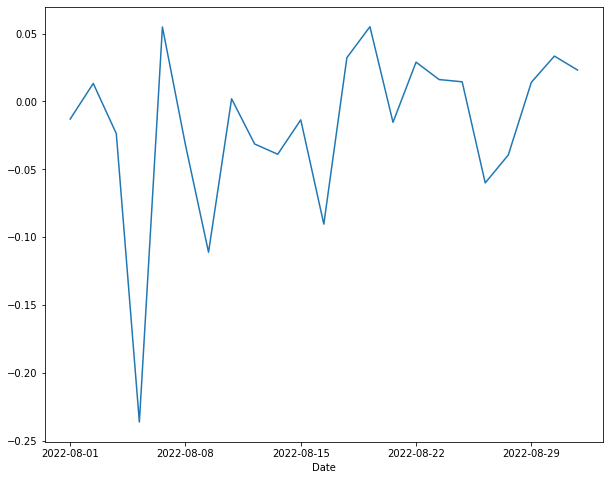

In [224]:
# plot portfolio daily return
portfolio_val_1_8['Total'].plot(figsize=(10,8))

In [225]:
sharpe_ratio = portfolio_val_1_8['Total'].mean() / portfolio_val_1_8['Total'].std()
sharpe_ratio

-0.28508316786859306

In [245]:
portfolio_val_1_8.to_csv('portfolio_val_1_8.csv', index=False)

#### Month 9:

In [226]:
date = "2022-09-01"
selected_stocks = strategy1(date)
factors = factors.loc[(factors["Date"]==date) & (factors["Index"].isin(selected_stocks))]
factor_returns = factor_returns.loc[factor_returns["Date"]==date]
factor_returns = factor_returns.iloc[:,1:]
stock_list = factors["Index"].tolist()
factors = factors.iloc[:, 3:]
factors = np.array(factors)
factor_returns = np.array(factor_returns)
stock_return = np.dot(factors, factor_returns.T).reshape(-1)
stock_list = np.array(stock_list)
stock_list

array(['ASML', 'HLNE', 'INMD', 'ITOS', 'MSFT', 'ORGO', 'QFIN', 'SSSS',
       'VIR', 'WIRE'], dtype='<U4')

In [227]:
date_piars = date_piars_9
results = []

In [228]:
for pair in date_piars:
    w=optimize(weights,tickers,pair[1],pair[0],calc_window,rf_rate,short=True,price_type='Adj Close',clean='True')
    weight=list(w.x)
    results.append(weight)  
len(results)

21

In [ ]:
factors = pd.read_csv("./Factors/merge_Factors.csv")

In [231]:
stock_df_list=[]
for idx, index in enumerate(stock_list):
    weight_list = []
    for w in results:
        weight_list.append(w[idx])
    stock_true = factors.loc[(factors["Date"]>='2022-09-01') & (factors["Date"]<='2022-09-30') & (factors["Index"]==index)]
    stock_true = stock_true[['Date', 'Return']].reset_index(drop=True)
    stock_true['Weight'] = weight_list
    stock_true['Daily Return'] = stock_true['Return'] * stock_true['Weight']
    stock_true = stock_true.set_index("Date")
    stock_df_list.append(stock_true)

In [232]:
all_vals = [stock_df['Daily Return'] for stock_df in stock_df_list]
portfolio_val_1_9 = pd.concat(all_vals, axis=1)
portfolio_val_1_9.columns = stock_list
portfolio_val_1_9['Total'] = portfolio_val_1_9.sum(axis=1)

<AxesSubplot: xlabel='Date'>

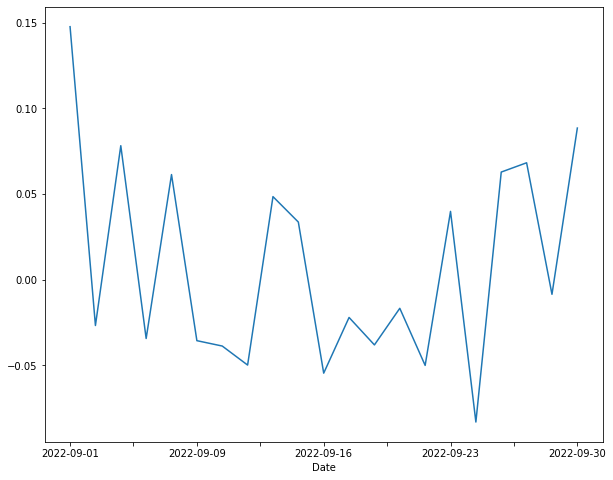

In [233]:
# plot portfolio daily return
portfolio_val_1_9['Total'].plot(figsize=(10,8))

In [234]:
sharpe_ratio = portfolio_val_1_9['Total'].mean() / portfolio_val_1_9['Total'].std()
sharpe_ratio

0.13305453804230974

In [246]:
portfolio_val_1_9.to_csv('portfolio_val_1_9.csv', index=False)

#### Month 10:

In [235]:
date = "2022-10-03"
selected_stocks = strategy1(date)
factors = factors.loc[(factors["Date"]==date) & (factors["Index"].isin(selected_stocks))]
factor_returns = factor_returns.loc[factor_returns["Date"]==date]
factor_returns = factor_returns.iloc[:,1:]
stock_list = factors["Index"].tolist()
factors = factors.iloc[:, 3:]
factors = np.array(factors)
factor_returns = np.array(factor_returns)
stock_return = np.dot(factors, factor_returns.T).reshape(-1)
stock_list = np.array(stock_list)
stock_list

array(['AFMD', 'CARG', 'CPRX', 'IPWR', 'KYMR', 'MEIP', 'MSTR', 'OPRT',
       'OYST', 'PTEN'], dtype='<U4')

In [236]:
date_piars = date_piars_10
results = []

In [237]:
for pair in date_piars:
    w=optimize(weights,tickers,pair[1],pair[0],calc_window,rf_rate,short=True,price_type='Adj Close',clean='True')
    weight=list(w.x)
    results.append(weight)  
len(results)

21

In [ ]:
factors = pd.read_csv("./Factors/merge_Factors.csv")

In [240]:
stock_df_list=[]
for idx, index in enumerate(stock_list):
    weight_list = []
    for w in results:
        weight_list.append(w[idx])
    stock_true = factors.loc[(factors["Date"]>='2022-10-01') & (factors["Date"]<='2022-10-31') & (factors["Index"]==index)]
    stock_true = stock_true[['Date', 'Return']].reset_index(drop=True)
    stock_true['Weight'] = weight_list
    stock_true['Daily Return'] = stock_true['Return'] * stock_true['Weight']
    stock_true = stock_true.set_index("Date")
    stock_df_list.append(stock_true)

In [241]:
all_vals = [stock_df['Daily Return'] for stock_df in stock_df_list]
portfolio_val_1_10 = pd.concat(all_vals, axis=1)
portfolio_val_1_10.columns = stock_list
portfolio_val_1_10['Total'] = portfolio_val_1_10.sum(axis=1)

In [242]:
portfolio_val_1_10

,AFMD,CARG,CPRX,IPWR,KYMR,MEIP,MSTR,OPRT,OYST,PTEN,Total
Date,,,,,,,,,,,
2022-10-03,-0.038835,-0.052929,0.024162,-0.082126,-0.032166,-0.014387,0.057759,0.032597,0.044484,0.003866,-0.057574
2022-10-04,-0.001640,-0.020777,-0.029680,-0.005123,-0.017856,-0.032240,0.107875,0.081605,0.052553,-0.000961,0.133755
2022-10-05,0.030570,0.040709,-0.000784,0.009192,0.000357,-0.000000,-0.026333,-0.021555,0.013959,0.004501,0.050617
2022-10-06,0.017272,0.003422,-0.021193,-0.017253,-0.008643,0.011705,-0.002147,-0.007255,0.075472,0.002093,0.053473
2022-10-07,0.026077,0.039148,-0.017642,0.044466,-0.001999,0.025049,-0.088426,-0.010092,0.035088,-0.002144,0.049525
2022-10-10,0.142223,-0.004289,0.003265,0.007729,0.016693,0.017183,0.001589,-0.061053,-0.021186,-0.028691,0.073464
2022-10-11,0.018868,0.000712,0.018714,0.116823,-0.011061,0.007911,-0.019397,-0.025670,-0.044733,-0.014409,0.047757
2022-10-12,0.038462,-0.007835,-0.009585,0.027902,-0.001841,-0.011146,0.009290,0.019139,0.061934,0.006405,0.132725
2022-10-13,-0.040000,0.004240,0.042742,-0.118255,-0.006260,-0.010319,0.009891,0.033129,0.049787,0.038923,0.003878


<AxesSubplot: xlabel='Date'>

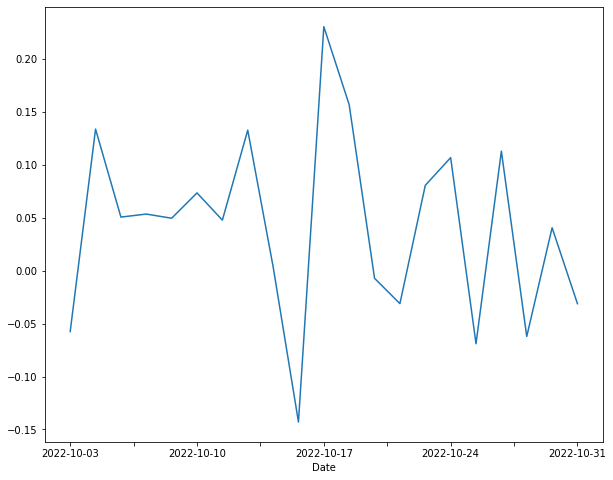

In [243]:
# plot portfolio daily return
portfolio_val_1_10['Total'].plot(figsize=(10,8))

In [244]:
sharpe_ratio = portfolio_val_1_10['Total'].mean() / portfolio_val_1_10['Total'].std()
sharpe_ratio

0.4653577052331418

In [247]:
portfolio_val_1_10.to_csv('portfolio_val_1_10.csv', index=False)

## Strategy 2:

#### Month 8:

In [248]:
date = "2022-08-01"
selected_stocks = strategy2(date)
factors = factors.loc[(factors["Date"]==date) & (factors["Index"].isin(selected_stocks))]
factor_returns = factor_returns.loc[factor_returns["Date"]==date]
factor_returns = factor_returns.iloc[:,1:]
stock_list = factors["Index"].tolist()
factors = factors.iloc[:, 3:]
factors = np.array(factors)
factor_returns = np.array(factor_returns)
stock_return = np.dot(factors, factor_returns.T).reshape(-1)
stock_list = np.array(stock_list)
stock_list

array(['AMAL', 'DAIO', 'DGICB', 'FOCS', 'HBCP', 'MMYT', 'NFBK', 'OBNK',
       'PDFS', 'STEL'], dtype='<U5')

In [249]:
date_piars = date_piars_8
results = []

In [250]:
for pair in date_piars:
    w=optimize(weights,tickers,pair[1],pair[0],calc_window,rf_rate,short=True,price_type='Adj Close',clean='True')
    weight=list(w.x)
    results.append(weight)  
len(results)

23

In [ ]:
factors = pd.read_csv("./Factors/merge_Factors.csv")

In [253]:
stock_df_list=[]
for idx, index in enumerate(stock_list):
    weight_list = []
    for w in results:
        weight_list.append(w[idx])
    stock_true = factors.loc[(factors["Date"]>='2022-08-01') & (factors["Date"]<='2022-08-31') & (factors["Index"]==index)]
    stock_true = stock_true[['Date', 'Return']].reset_index(drop=True)
    stock_true['Weight'] = weight_list
    stock_true['Daily Return'] = stock_true['Return'] * stock_true['Weight']
    stock_true = stock_true.set_index("Date")
    stock_df_list.append(stock_true)

In [254]:
all_vals = [stock_df['Daily Return'] for stock_df in stock_df_list]
portfolio_val_2_8 = pd.concat(all_vals, axis=1)
portfolio_val_2_8.columns = stock_list
portfolio_val_2_8['Total'] = portfolio_val_2_8.sum(axis=1)

<AxesSubplot: xlabel='Date'>

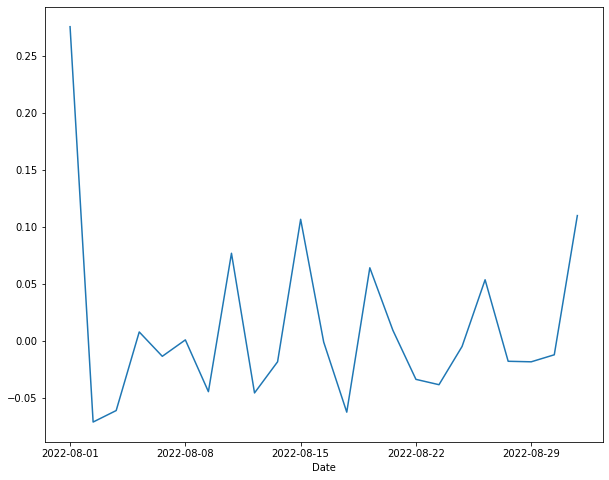

In [255]:
# plot portfolio daily return
portfolio_val_2_8['Total'].plot(figsize=(10,8))

In [256]:
sharpe_ratio = portfolio_val_2_8['Total'].mean() / portfolio_val_2_8['Total'].std()
sharpe_ratio

0.1449342790296325

In [257]:
portfolio_val_2_8.to_csv('portfolio_val_2_8.csv', index=False)

#### Month 9:

In [258]:
date = "2022-09-01"
selected_stocks = strategy2(date)
factors = factors.loc[(factors["Date"]==date) & (factors["Index"].isin(selected_stocks))]
factor_returns = factor_returns.loc[factor_returns["Date"]==date]
factor_returns = factor_returns.iloc[:,1:]
stock_list = factors["Index"].tolist()
factors = factors.iloc[:, 3:]
factors = np.array(factors)
factor_returns = np.array(factor_returns)
stock_return = np.dot(factors, factor_returns.T).reshape(-1)
stock_list = np.array(stock_list)
stock_list

array(['BFIN', 'CRTO', 'DGICB', 'FFBW', 'LRFC', 'NFBK', 'PDLB', 'RDCM',
       'SCOR', 'TACT'], dtype='<U5')

In [259]:
date_piars = date_piars_9
results = []

In [260]:
for pair in date_piars:
    w=optimize(weights,tickers,pair[1],pair[0],calc_window,rf_rate,short=True,price_type='Adj Close',clean='True')
    weight=list(w.x)
    results.append(weight)  
len(results)

21

In [ ]:
factors = pd.read_csv("./Factors/merge_Factors.csv")

In [263]:
stock_df_list=[]
for idx, index in enumerate(stock_list):
    weight_list = []
    for w in results:
        weight_list.append(w[idx])
    stock_true = factors.loc[(factors["Date"]>='2022-09-01') & (factors["Date"]<='2022-09-30') & (factors["Index"]==index)]
    stock_true = stock_true[['Date', 'Return']].reset_index(drop=True)
    stock_true['Weight'] = weight_list
    stock_true['Daily Return'] = stock_true['Return'] * stock_true['Weight']
    stock_true = stock_true.set_index("Date")
    stock_df_list.append(stock_true)

In [264]:
all_vals = [stock_df['Daily Return'] for stock_df in stock_df_list]
portfolio_val_2_9 = pd.concat(all_vals, axis=1)
portfolio_val_2_9.columns = stock_list
portfolio_val_2_9['Total'] = portfolio_val_2_9.sum(axis=1)

<AxesSubplot: xlabel='Date'>

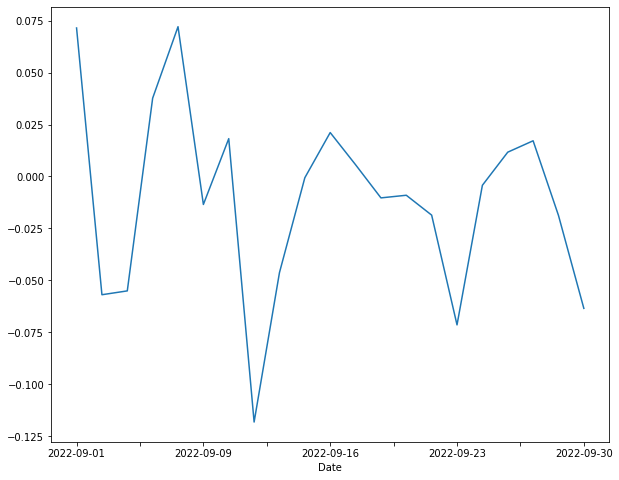

In [265]:
# plot portfolio daily return
portfolio_val_2_9['Total'].plot(figsize=(10,8))

In [266]:
sharpe_ratio = portfolio_val_2_9['Total'].mean() / portfolio_val_2_9['Total'].std()
sharpe_ratio

-0.23746715261735074

In [267]:
portfolio_val_2_9.to_csv('portfolio_val_2_9.csv', index=False)

#### Month 10:

In [268]:
date = "2022-10-03"
selected_stocks = strategy2(date)
factors = factors.loc[(factors["Date"]==date) & (factors["Index"].isin(selected_stocks))]
factor_returns = factor_returns.loc[factor_returns["Date"]==date]
factor_returns = factor_returns.iloc[:,1:]
stock_list = factors["Index"].tolist()
factors = factors.iloc[:, 3:]
factors = np.array(factors)
factor_returns = np.array(factor_returns)
stock_return = np.dot(factors, factor_returns.T).reshape(-1)
stock_list = np.array(stock_list)
stock_list

array(['AFBI', 'BSBK', 'CFB', 'CLBK', 'FBNC', 'FFBW', 'FSEA', 'LSBK',
       'MGYR', 'RBKB'], dtype='<U4')

In [269]:
date_piars = date_piars_10
results = []

In [270]:
for pair in date_piars:
    w=optimize(weights,tickers,pair[1],pair[0],calc_window,rf_rate,short=True,price_type='Adj Close',clean='True')
    weight=list(w.x)
    results.append(weight)  
len(results)

21

In [ ]:
factors = pd.read_csv("./Factors/merge_Factors.csv")

In [273]:
stock_df_list=[]
for idx, index in enumerate(stock_list):
    weight_list = []
    for w in results:
        weight_list.append(w[idx])
    stock_true = factors.loc[(factors["Date"]>='2022-10-01') & (factors["Date"]<='2022-10-31') & (factors["Index"]==index)]
    stock_true = stock_true[['Date', 'Return']].reset_index(drop=True)
    stock_true['Weight'] = weight_list
    stock_true['Daily Return'] = stock_true['Return'] * stock_true['Weight']
    stock_true = stock_true.set_index("Date")
    stock_df_list.append(stock_true)

In [274]:
all_vals = [stock_df['Daily Return'] for stock_df in stock_df_list]
portfolio_val_2_10 = pd.concat(all_vals, axis=1)
portfolio_val_2_10.columns = stock_list
portfolio_val_2_10['Total'] = portfolio_val_2_10.sum(axis=1)

<AxesSubplot: xlabel='Date'>

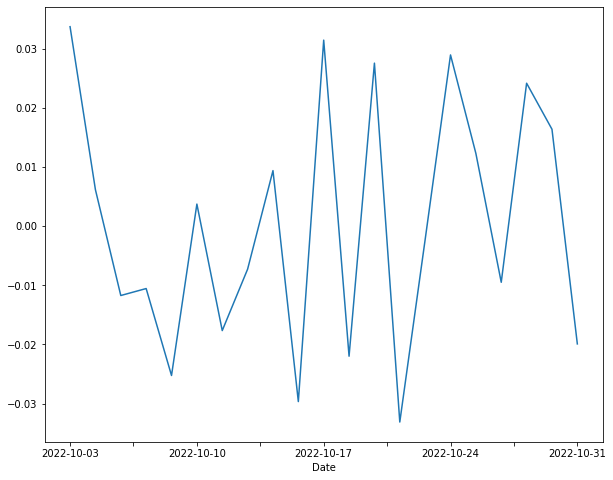

In [275]:
# plot portfolio daily return
portfolio_val_2_10['Total'].plot(figsize=(10,8))

In [276]:
sharpe_ratio = portfolio_val_2_10['Total'].mean() / portfolio_val_2_10['Total'].std()
sharpe_ratio

0.011172877699074652

In [277]:
portfolio_val_2_10.to_csv('portfolio_val_2_10.csv', index=False)

## Strategy 3:

#### Month 8:

In [278]:
date = "2022-08-01"
selected_stocks = strategy3(date)
factors = factors.loc[(factors["Date"]==date) & (factors["Index"].isin(selected_stocks))]
factor_returns = factor_returns.loc[factor_returns["Date"]==date]
factor_returns = factor_returns.iloc[:,1:]
stock_list = factors["Index"].tolist()
factors = factors.iloc[:, 3:]
factors = np.array(factors)
factor_returns = np.array(factor_returns)
stock_return = np.dot(factors, factor_returns.T).reshape(-1)
stock_list = np.array(stock_list)
stock_list

array(['AMAL', 'ANGO', 'AXON', 'DAIO', 'DGICB', 'FOCS', 'HBCP', 'NFBK',
       'PDFS', 'STEL'], dtype='<U5')

In [279]:
date_piars = date_piars_8
results = []

In [280]:
for pair in date_piars:
    w=optimize(weights,tickers,pair[1],pair[0],calc_window,rf_rate,short=True,price_type='Adj Close',clean='True')
    weight=list(w.x)
    results.append(weight)  
len(results)

23

In [ ]:
factors = pd.read_csv("./Factors/merge_Factors.csv")

In [283]:
stock_df_list=[]
for idx, index in enumerate(stock_list):
    weight_list = []
    for w in results:
        weight_list.append(w[idx])
    stock_true = factors.loc[(factors["Date"]>='2022-08-01') & (factors["Date"]<='2022-08-31') & (factors["Index"]==index)]
    stock_true = stock_true[['Date', 'Return']].reset_index(drop=True)
    stock_true['Weight'] = weight_list
    stock_true['Daily Return'] = stock_true['Return'] * stock_true['Weight']
    stock_true = stock_true.set_index("Date")
    stock_df_list.append(stock_true)

In [284]:
all_vals = [stock_df['Daily Return'] for stock_df in stock_df_list]
portfolio_val_3_8 = pd.concat(all_vals, axis=1)
portfolio_val_3_8.columns = stock_list
portfolio_val_3_8['Total'] = portfolio_val_3_8.sum(axis=1)

<AxesSubplot: xlabel='Date'>

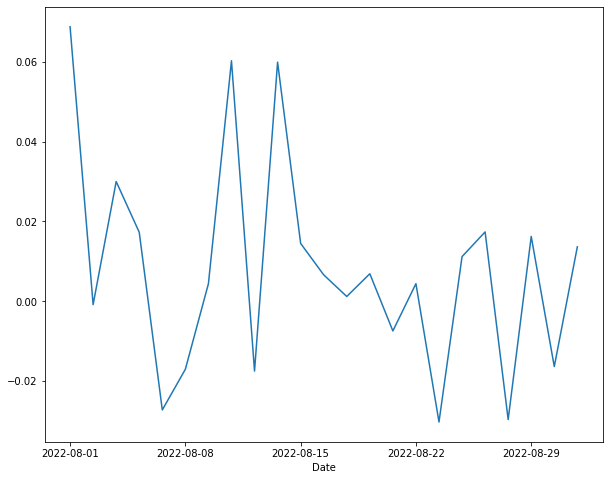

In [285]:
# plot portfolio daily return
portfolio_val_3_8['Total'].plot(figsize=(10,8))

In [286]:
sharpe_ratio = portfolio_val_3_8['Total'].mean() / portfolio_val_3_8['Total'].std()
sharpe_ratio

0.29790262332427125

In [287]:
portfolio_val_3_8.to_csv('portfolio_val_3_8.csv', index=False)

#### Month 9:

In [288]:
date = "2022-09-01"
selected_stocks = strategy3(date)
factors = factors.loc[(factors["Date"]==date) & (factors["Index"].isin(selected_stocks))]
factor_returns = factor_returns.loc[factor_returns["Date"]==date]
factor_returns = factor_returns.iloc[:,1:]
stock_list = factors["Index"].tolist()
factors = factors.iloc[:, 3:]
factors = np.array(factors)
factor_returns = np.array(factor_returns)
stock_return = np.dot(factors, factor_returns.T).reshape(-1)
stock_list = np.array(stock_list)
stock_list

array(['BFIN', 'CRTO', 'DGICB', 'FFBW', 'LRFC', 'PDLB', 'RDCM', 'SCOR',
       'TACT', 'VIA'], dtype='<U5')

In [289]:
date_piars = date_piars_9
results = []

In [290]:
for pair in date_piars:
    w=optimize(weights,tickers,pair[1],pair[0],calc_window,rf_rate,short=True,price_type='Adj Close',clean='True')
    weight=list(w.x)
    results.append(weight)  
len(results)

21

In [ ]:
factors = pd.read_csv("./Factors/merge_Factors.csv")

In [292]:
stock_df_list=[]
for idx, index in enumerate(stock_list):
    weight_list = []
    for w in results:
        weight_list.append(w[idx])
    stock_true = factors.loc[(factors["Date"]>='2022-09-01') & (factors["Date"]<='2022-09-30') & (factors["Index"]==index)]
    stock_true = stock_true[['Date', 'Return']].reset_index(drop=True)
    stock_true['Weight'] = weight_list
    stock_true['Daily Return'] = stock_true['Return'] * stock_true['Weight']
    stock_true = stock_true.set_index("Date")
    stock_df_list.append(stock_true)

In [293]:
all_vals = [stock_df['Daily Return'] for stock_df in stock_df_list]
portfolio_val_3_9 = pd.concat(all_vals, axis=1)
portfolio_val_3_9.columns = stock_list
portfolio_val_3_9['Total'] = portfolio_val_3_9.sum(axis=1)

<AxesSubplot: xlabel='Date'>

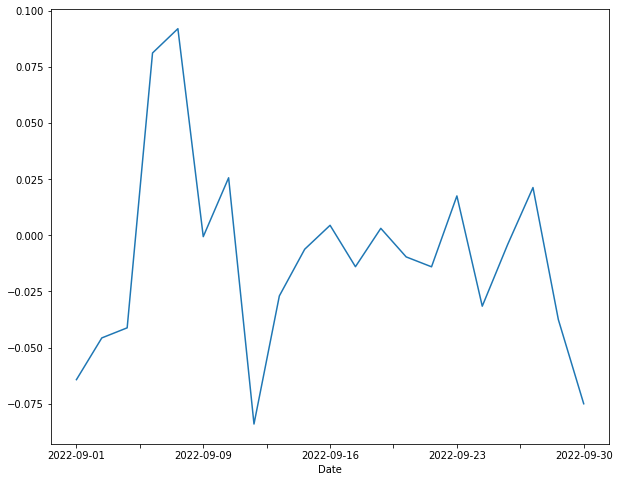

In [294]:
# plot portfolio daily return
portfolio_val_3_9['Total'].plot(figsize=(10,8))

In [295]:
sharpe_ratio = portfolio_val_3_9['Total'].mean() / portfolio_val_3_9['Total'].std()
sharpe_ratio

-0.22726676322757075

In [296]:
portfolio_val_3_9.to_csv('portfolio_val_3_9.csv', index=False)

#### Month 10:

In [297]:
date = "2022-10-03"
selected_stocks = strategy3(date)
factors = factors.loc[(factors["Date"]==date) & (factors["Index"].isin(selected_stocks))]
factor_returns = factor_returns.loc[factor_returns["Date"]==date]
factor_returns = factor_returns.iloc[:,1:]
stock_list = factors["Index"].tolist()
factors = factors.iloc[:, 3:]
factors = np.array(factors)
factor_returns = np.array(factor_returns)
stock_return = np.dot(factors, factor_returns.T).reshape(-1)
stock_list = np.array(stock_list)
stock_list

array(['AFBI', 'AXON', 'BOXL', 'BSBK', 'FFBW', 'FSEA', 'IROQ', 'MGYR',
       'RBKB', 'SBT'], dtype='<U4')

In [298]:
date_piars = date_piars_10
results = []

In [299]:
for pair in date_piars:
    w=optimize(weights,tickers,pair[1],pair[0],calc_window,rf_rate,short=True,price_type='Adj Close',clean='True')
    weight=list(w.x)
    results.append(weight)  
len(results)

21

In [ ]:
factors = pd.read_csv("./Factors/merge_Factors.csv")

In [301]:
stock_df_list=[]
for idx, index in enumerate(stock_list):
    weight_list = []
    for w in results:
        weight_list.append(w[idx])
    stock_true = factors.loc[(factors["Date"]>='2022-10-01') & (factors["Date"]<='2022-10-31') & (factors["Index"]==index)]
    stock_true = stock_true[['Date', 'Return']].reset_index(drop=True)
    stock_true['Weight'] = weight_list
    stock_true['Daily Return'] = stock_true['Return'] * stock_true['Weight']
    stock_true = stock_true.set_index("Date")
    stock_df_list.append(stock_true)

In [302]:
all_vals = [stock_df['Daily Return'] for stock_df in stock_df_list]
portfolio_val_3_10 = pd.concat(all_vals, axis=1)
portfolio_val_3_10.columns = stock_list
portfolio_val_3_10['Total'] = portfolio_val_3_10.sum(axis=1)

<AxesSubplot: xlabel='Date'>

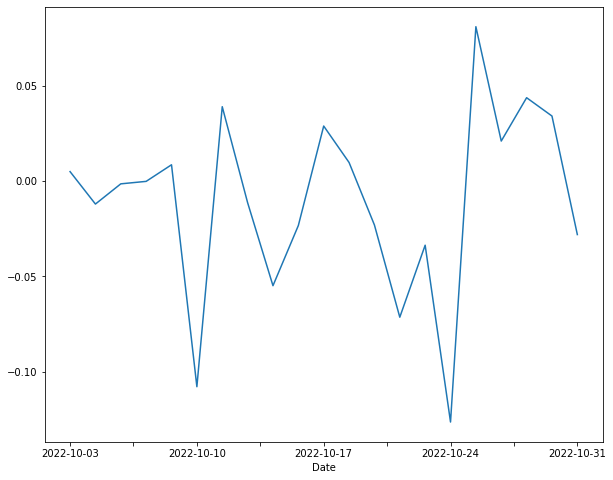

In [303]:
# plot portfolio daily return
portfolio_val_3_10['Total'].plot(figsize=(10,8))

In [304]:
sharpe_ratio = portfolio_val_3_10['Total'].mean() / portfolio_val_3_10['Total'].std()
sharpe_ratio

-0.21473298151337822

In [305]:
portfolio_val_3_10.to_csv('portfolio_val_3_10.csv', index=False)